# Differential Expression Analysis of Mouse Mammary RNA-seq with edgePython

This notebook analyzes bulk RNA-seq gene-count data from the mouse mammary gland study by **Fu et al. (2015)** using **edgePython**, a Python implementation of edgeR.

The data profile epithelial cell-state changes across development, comparing basal and luminal cell populations across virgin, pregnant, and lactating stages.

## Dataset

**GSE60450** (Fu et al., 2015): RNA-seq of the mouse mammary gland. The experiment examines gene expression in two cell types (basal and luminal) across three developmental stages (virgin, pregnant, lactate), with 2 biological replicates per condition (12 samples total, 6 groups).

- **Reference**: Fu NY, Rios AC, Pal B et al. (2015). EGF-mediated induction of Mcl-1 at the switch to lactation is essential for alveolar cell survival. *Nature Cell Biology* 17, 365-375.

In [1]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

try:
    import edgepython as ep
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'edgepython'])
    import edgepython as ep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# Download data files from the GitHub repository
BASE_URL = 'https://raw.githubusercontent.com/pachterlab/edgePython/main/examples/mammary/data'

counts_df = pd.read_csv(f'{BASE_URL}/countdata.tsv', sep='\t', index_col=0)
factor_df = pd.read_csv(f'{BASE_URL}/sampleinfo.tsv', sep='\t')

print(f'Count matrix: {counts_df.shape[0]} genes x {counts_df.shape[1]} samples')
print(f'Samples: {list(counts_df.columns)}')

Count matrix: 27179 genes x 12 samples
Samples: ['MCL1.DG', 'MCL1.DH', 'MCL1.DI', 'MCL1.DJ', 'MCL1.DK', 'MCL1.DL', 'MCL1.LA', 'MCL1.LB', 'MCL1.LC', 'MCL1.LD', 'MCL1.LE', 'MCL1.LF']


In [2]:
# Publication-quality figure defaults
plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13,
    'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'legend.fontsize': 10, 'figure.figsize': (8, 5),
    'axes.spines.top': False, 'axes.spines.right': False,
})

group_colors = {
    'basalvirgin': '#E41A1C', 'basalpregnant': '#377EB8', 'basallactate': '#4DAF4A',
    'luminalvirgin': '#984EA3', 'luminalpregnant': '#FF7F00', 'luminallactate': '#A65628'
}

## 1. Create DGEList

In [3]:
group = factor_df.set_index('SampleName').loc[counts_df.columns, 'CellTypeStatus'].values
gene_ids = counts_df.index.values.astype(str)
sample_names = counts_df.columns.tolist()

genes_df = pd.DataFrame({'GeneID': gene_ids})
d = ep.make_dgelist(counts_df.values.astype(float), group=group, genes=genes_df)
print(f"DGEList: {d['counts'].shape[0]} genes, {d['counts'].shape[1]} samples")
print(f"Library sizes: {d['samples']['lib.size'].values}")

DGEList: 27179 genes, 12 samples
Library sizes: [23227641. 21777891. 24100765. 22665371. 21529331. 20015386. 20392113.
 21708152. 22241607. 21988240. 24723827. 24657293.]


## 2. Library Sizes

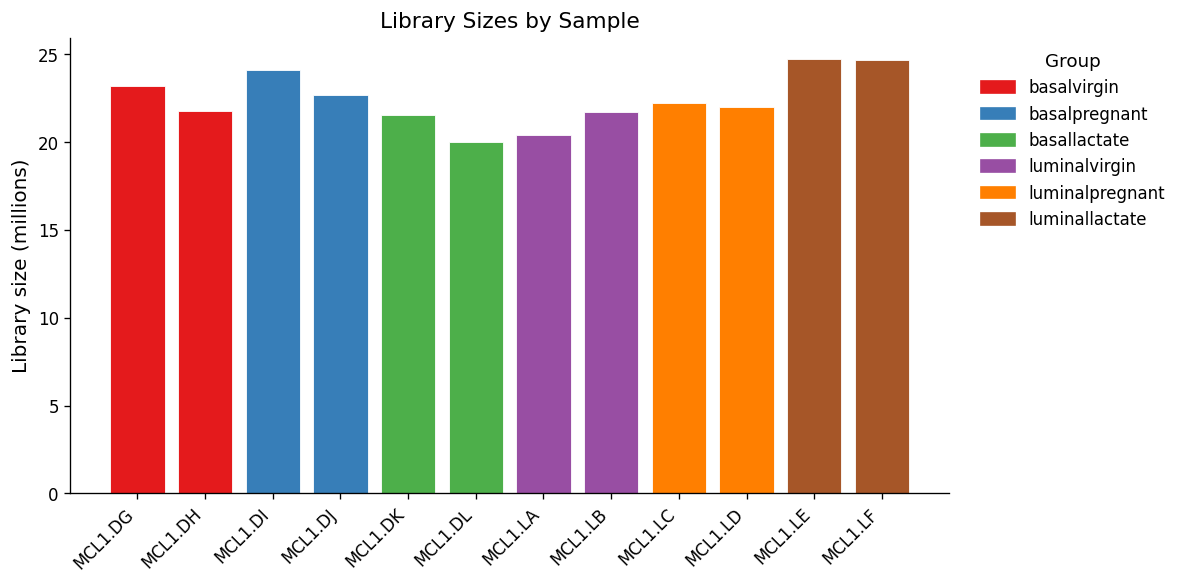

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
lib_sizes = d['samples']['lib.size'].values / 1e6
colors = [group_colors[g] for g in group]
ax.bar(range(len(lib_sizes)), lib_sizes, color=colors, edgecolor='white', linewidth=0.5)
ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=45, ha='right')
ax.set_ylabel('Library size (millions)')
ax.set_title('Library Sizes by Sample')
handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
ax.legend(handles=handles, title='Group', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

## 3. Filter Low-Expression Genes

We keep genes with CPM > 0.5 in at least 2 samples.

In [5]:
cpm_vals = ep.cpm(d)
keep = np.sum(cpm_vals > 0.5, axis=1) >= 2
print(f'Genes before filtering: {d["counts"].shape[0]}')
print(f'Genes after filtering:  {np.sum(keep)}')
print(f'Genes removed:          {np.sum(~keep)}')

d_filt = ep.make_dgelist(d['counts'][keep, :], group=group,
                         genes=pd.DataFrame({'GeneID': gene_ids[keep]}))

Genes before filtering: 27179
Genes after filtering:  15804
Genes removed:          11375


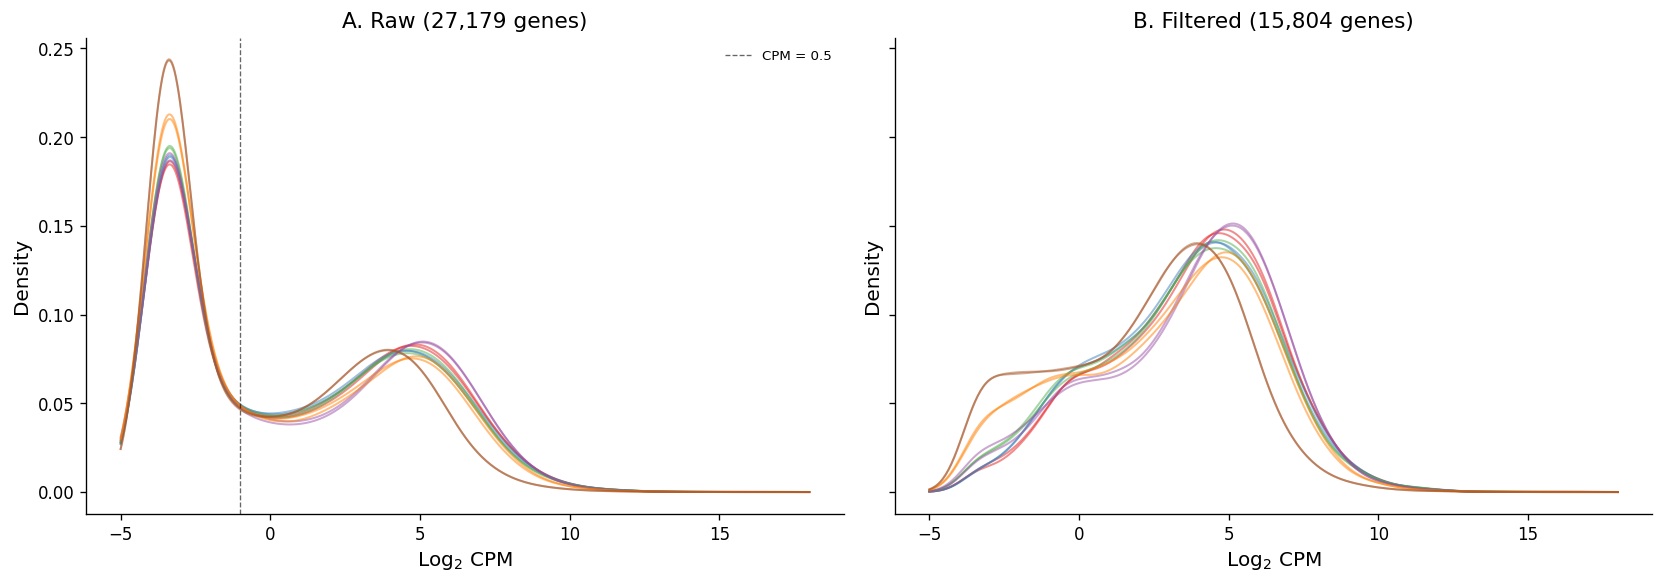

In [6]:
# Density plot of log-CPM before and after filtering
from scipy.stats import gaussian_kde

full_lib_size = d['samples']['lib.size'].values  # lib sizes from all 27,179 genes

logcpm_before = ep.cpm(d, log=True)
# After filtering: keep genes only, but use full lib sizes (not recomputed from filtered counts)
logcpm_after = ep.cpm(d['counts'][keep, :], lib_size=full_lib_size, log=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True, sharex=True)
x_grid = np.linspace(-5, 18, 500)

for i in range(len(sample_names)):
    c = group_colors[group[i]]
    kde_before = gaussian_kde(logcpm_before[:, i], bw_method=0.2)
    ax1.plot(x_grid, kde_before(x_grid), color=c, alpha=0.5, linewidth=1.2)
    kde_after = gaussian_kde(logcpm_after[:, i], bw_method=0.2)
    ax2.plot(x_grid, kde_after(x_grid), color=c, alpha=0.5, linewidth=1.2)

ax1.set_xlabel('Log$_2$ CPM'); ax1.set_ylabel('Density')
ax1.set_title(f'A. Raw ({logcpm_before.shape[0]:,} genes)')
ax1.axvline(x=np.log2(0.5), color='black', linestyle='--', linewidth=0.8,
            alpha=0.6, label='CPM = 0.5')
ax1.legend(frameon=False, fontsize=8)

ax2.set_xlabel('Log$_2$ CPM'); ax2.set_ylabel('Density')
ax2.set_title(f'B. Filtered ({logcpm_after.shape[0]:,} genes)')
plt.tight_layout()
plt.show()

## 4. TMM Normalization

In [7]:
d_filt = ep.calc_norm_factors(d_filt)
print('Normalization factors:')
print(d_filt['samples'][['group', 'lib.size', 'norm.factors']])

Normalization factors:
                    group    lib.size  norm.factors
Sample1       basalvirgin  23218026.0      1.236914
Sample2       basalvirgin  21768136.0      1.213963
Sample3     basalpregnant  24091588.0      1.125579
Sample4     basalpregnant  22656713.0      1.069839
Sample5      basallactate  21522033.0      1.035934
Sample6      basallactate  20008326.0      1.087228
Sample7     luminalvirgin  20384562.0      1.368241
Sample8     luminalvirgin  21698793.0      1.365357
Sample9   luminalpregnant  22235847.0      1.004755
Sample10  luminalpregnant  21982745.0      0.923293
Sample11   luminallactate  24719697.0      0.529108
Sample12   luminallactate  24652963.0      0.535494


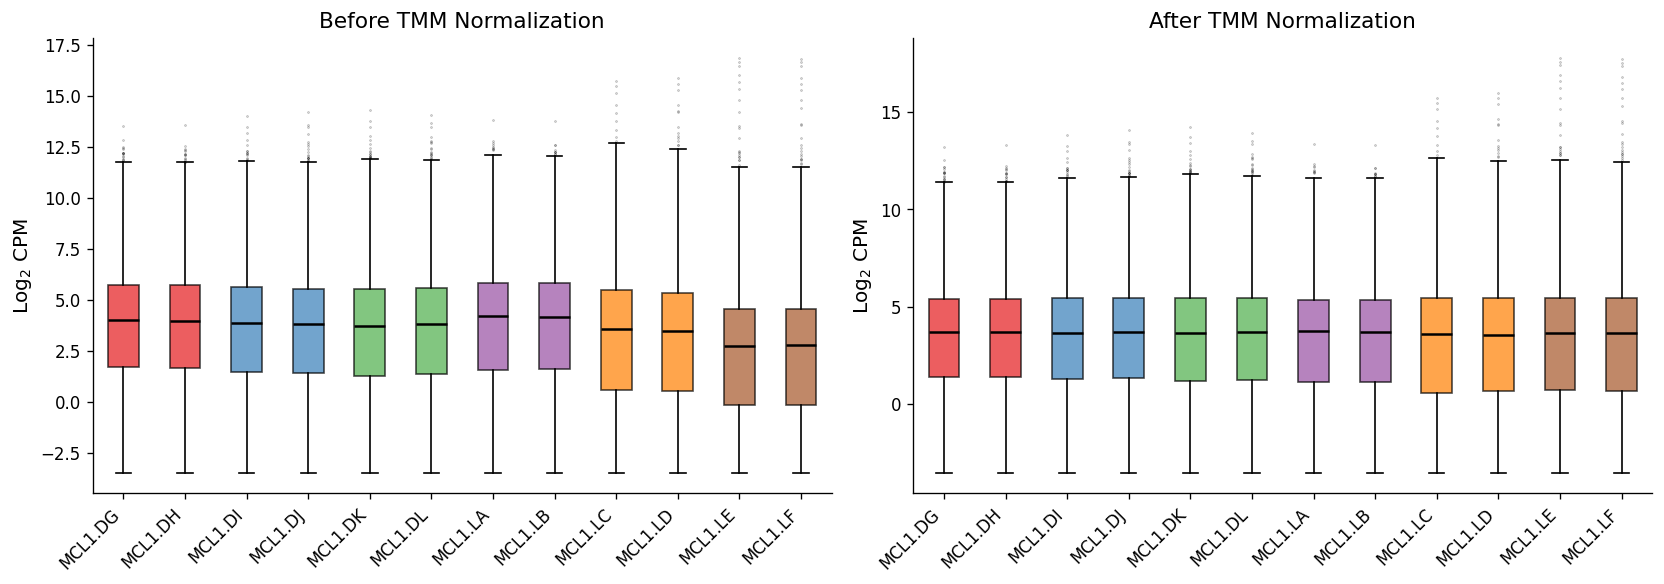

In [8]:
# Box plots of log-CPM before and after normalization
import copy
logcpm_norm = ep.cpm(d_filt, log=True)
d_unnorm = copy.deepcopy(d_filt)
d_unnorm['samples']['norm.factors'] = 1.0
logcpm_unnorm = ep.cpm(d_unnorm, log=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, title in [(ax1, logcpm_unnorm, 'Before TMM Normalization'),
                         (ax2, logcpm_norm, 'After TMM Normalization')]:
    bp = ax.boxplot([data[:, i] for i in range(data.shape[1])],
                    patch_artist=True, medianprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='.', markersize=1, alpha=0.3))
    for patch, g in zip(bp['boxes'], group):
        patch.set_facecolor(group_colors[g]); patch.set_alpha(0.7)
    ax.set_xticklabels(sample_names, rotation=45, ha='right')
    ax.set_ylabel('Log$_2$ CPM'); ax.set_title(title)
plt.tight_layout()
plt.show()

## 5. MDS Plot

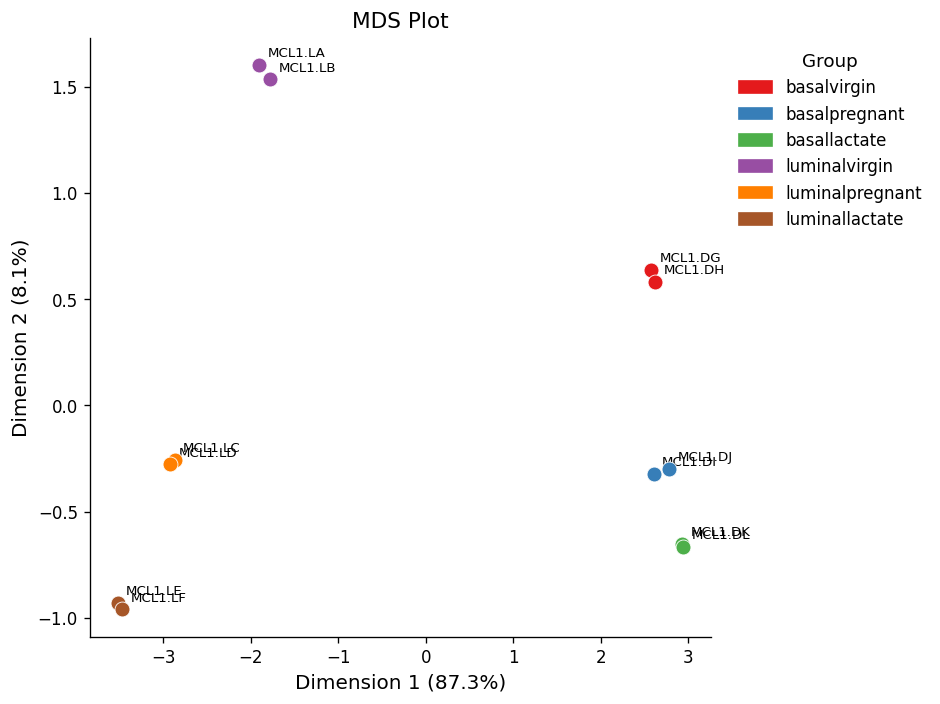

In [9]:
fig, ax = ep.plot_mds(d_filt)
collections = ax.collections
if len(collections) > 0:
    xy = collections[0].get_offsets()
    collections[0].remove()
    for txt in ax.texts[:]:
        txt.remove()
    for i in range(len(xy)):
        ax.scatter(xy[i, 0], xy[i, 1], c=group_colors[group[i]], s=80,
                   edgecolors='white', linewidth=0.5, zorder=5)
        ax.annotate(sample_names[i], (xy[i, 0], xy[i, 1]),
                    fontsize=8, ha='left', va='bottom',
                    xytext=(5, 3), textcoords='offset points')
    handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
    ax.legend(handles=handles, title='Group', bbox_to_anchor=(1.02, 1),
              loc='upper left', frameon=False)
ax.set_title('MDS Plot')
plt.tight_layout()
plt.show()

## 6. Design Matrix

We use a model without intercept (`~ 0 + group`), where each column represents a group mean.

In [10]:
import patsy
design_df = pd.DataFrame({'group': group})
design = ep.model_matrix('~ 0 + group', design_df)
col_names = list(patsy.dmatrix('~ 0 + group', design_df, return_type='dataframe').columns)
print('Design matrix columns:', col_names)
print(f'Shape: {design.shape}')
pd.DataFrame(design, columns=col_names, index=sample_names)

Design matrix columns: ['group[basallactate]', 'group[basalpregnant]', 'group[basalvirgin]', 'group[luminallactate]', 'group[luminalpregnant]', 'group[luminalvirgin]']
Shape: (12, 6)


,group[basallactate],group[basalpregnant],group[basalvirgin],group[luminallactate],group[luminalpregnant],group[luminalvirgin]
MCL1.DG,0.0,0.0,1.0,0.0,0.0,0.0
MCL1.DH,0.0,0.0,1.0,0.0,0.0,0.0
MCL1.DI,0.0,1.0,0.0,0.0,0.0,0.0
MCL1.DJ,0.0,1.0,0.0,0.0,0.0,0.0
MCL1.DK,1.0,0.0,0.0,0.0,0.0,0.0
MCL1.DL,1.0,0.0,0.0,0.0,0.0,0.0
MCL1.LA,0.0,0.0,0.0,0.0,0.0,1.0
MCL1.LB,0.0,0.0,0.0,0.0,0.0,1.0
MCL1.LC,0.0,0.0,0.0,0.0,1.0,0.0
MCL1.LD,0.0,0.0,0.0,0.0,1.0,0.0


## 7. Estimate Dispersion

In [11]:
d_filt = ep.estimate_disp(d_filt, design=design)
print(f"Common dispersion: {d_filt['common.dispersion']:.6f}")
print(f"Common BCV:        {np.sqrt(d_filt['common.dispersion']):.6f}")

Common dispersion: 0.013436
Common BCV:        0.115915


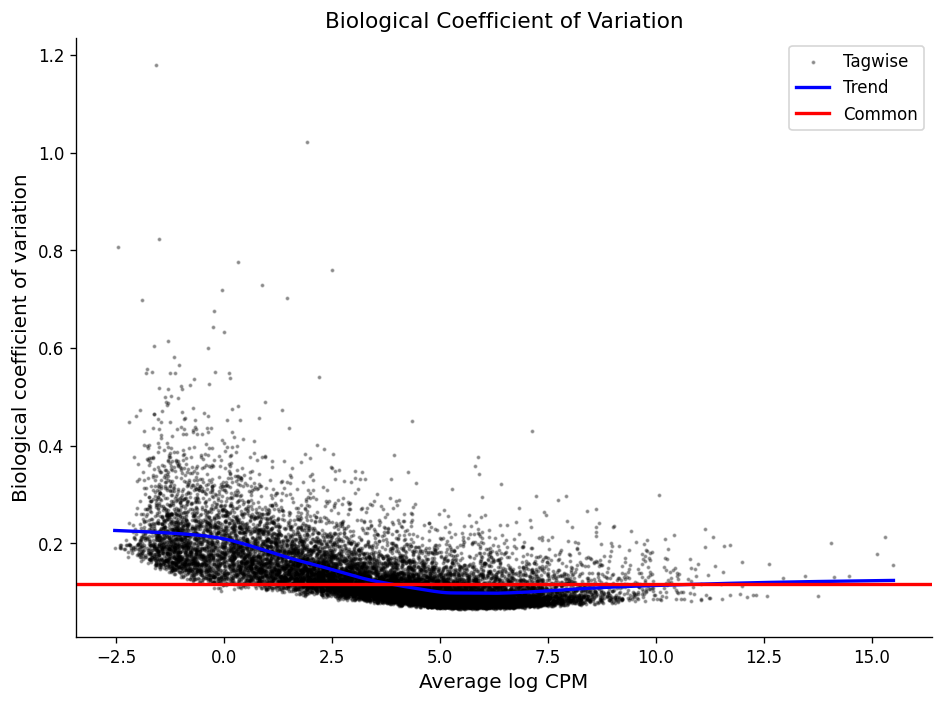

In [12]:
fig, ax = ep.plot_bcv(d_filt)
ax.set_title('Biological Coefficient of Variation')
plt.tight_layout()
plt.show()

## 8. Quasi-Likelihood F-test

In [13]:
fit = ep.glm_ql_fit(d_filt, design=design)
print(f"Prior df: {fit['df.prior']:.4f}")

Prior df: 6.3853


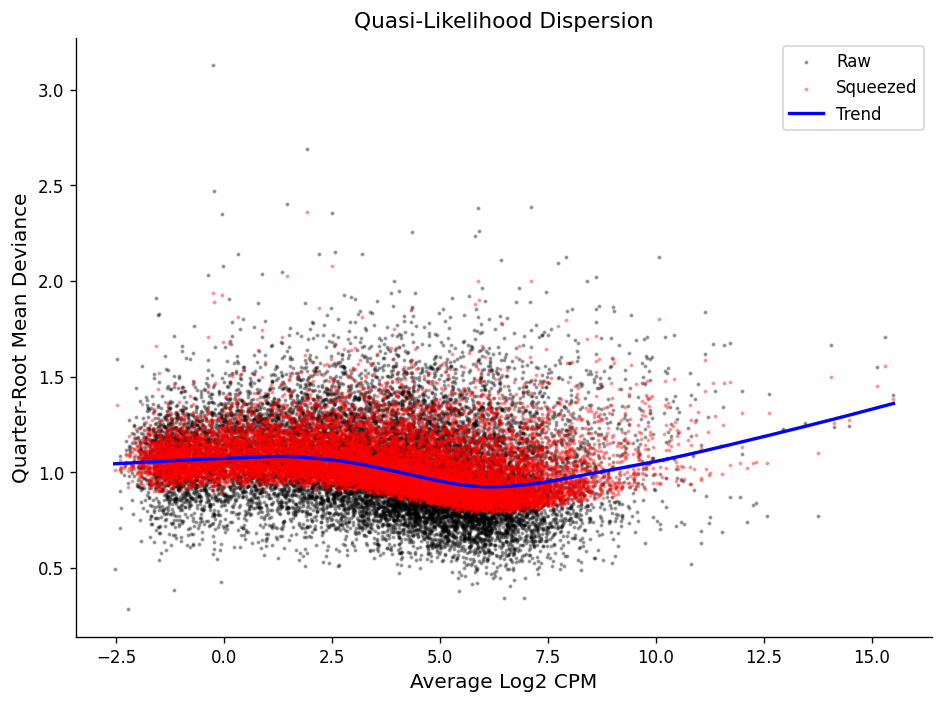

In [14]:
fig, ax = ep.plot_ql_disp(fit)
ax.set_title('Quasi-Likelihood Dispersion')
plt.tight_layout()
plt.show()

## 9. Contrast 1: Basal Pregnant vs. Lactate

Column order (alphabetical): basallactate, basalpregnant, basalvirgin, luminallactate, luminalpregnant, luminalvirgin

In [15]:
con_basal = np.array([-1, 1, 0, 0, 0, 0], dtype=float)
result_basal = ep.glm_ql_ftest(fit, contrast=con_basal)
tt_basal = ep.top_tags(result_basal, n=np.inf, sort_by='PValue')
table_basal = tt_basal['table']

dt_basal = ep.decide_tests(result_basal)
n_up = int(np.sum(dt_basal > 0))
n_down = int(np.sum(dt_basal < 0))
n_ns = int(np.sum(dt_basal == 0))
print(f'DE summary (FDR < 0.05): Up={n_up}, Down={n_down}, NS={n_ns}')
table_basal.head(10)

DE summary (FDR < 0.05): Up=2828, Down=2634, NS=10342


,GeneID,logFC,logCPM,PValue,F,FDR
13546,211577,-5.148743,2.742860,3.696010e-13,510.400255,5.841174e-09
10942,12992,-6.086161,10.182584,6.301711e-11,419.283621,3.441792e-07
1562,24117,1.820126,6.763739,7.420167e-11,311.202216,3.441792e-07
5599,140474,7.174306,6.051008,8.711193e-11,302.695066,3.441792e-07
13510,21953,-5.756241,3.857307,1.186761e-10,377.443937,3.751115e-07
135,78896,2.805269,6.679513,3.228514e-10,248.298550,7.064363e-07
543,381290,-2.144606,6.144094,3.448666e-10,316.371452,7.064363e-07
7415,226101,-2.323273,6.439672,3.575988e-10,314.219247,7.064363e-07
10177,14621,4.539511,5.537601,4.130132e-10,239.026433,7.252511e-07
10176,14620,3.580332,5.497731,6.081367e-10,281.341410,8.263060e-07


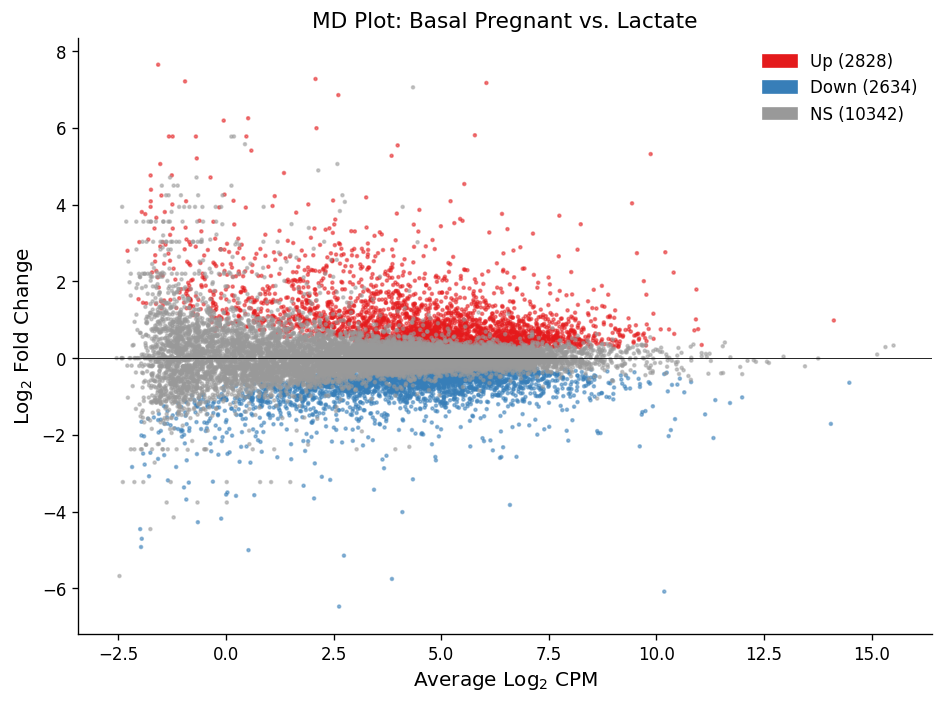

In [16]:
# MD plot
fig, ax = plt.subplots(figsize=(8, 6))
logfc = table_basal['logFC'].values
logcpm_mean = table_basal['logCPM'].values
fdr = table_basal['FDR'].values
sig = fdr < 0.05
colors_md = np.where(sig & (logfc > 0), '#E41A1C',
             np.where(sig & (logfc < 0), '#377EB8', '#999999'))
ax.scatter(logcpm_mean, logfc, c=colors_md, s=3, alpha=0.5, rasterized=True)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Average Log$_2$ CPM'); ax.set_ylabel('Log$_2$ Fold Change')
ax.set_title('MD Plot: Basal Pregnant vs. Lactate')
handles_md = [mpatches.Patch(color='#E41A1C', label=f'Up ({n_up})'),
              mpatches.Patch(color='#377EB8', label=f'Down ({n_down})'),
              mpatches.Patch(color='#999999', label=f'NS ({n_ns})')]
ax.legend(handles=handles_md, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

## 10. Contrast 2: Luminal Pregnant vs. Lactate

In [17]:
con_luminal = np.array([0, 0, 0, -1, 1, 0], dtype=float)
result_luminal = ep.glm_ql_ftest(fit, contrast=con_luminal)
tt_luminal = ep.top_tags(result_luminal, n=np.inf, sort_by='PValue')
table_luminal = tt_luminal['table']

dt_luminal = ep.decide_tests(result_luminal)
n_up_l = int(np.sum(dt_luminal > 0))
n_down_l = int(np.sum(dt_luminal < 0))
n_ns_l = int(np.sum(dt_luminal == 0))
print(f'DE summary (FDR < 0.05): Up={n_up_l}, Down={n_down_l}, NS={n_ns_l}')
table_luminal.head(10)

DE summary (FDR < 0.05): Up=3845, Down=3734, NS=8225


,GeneID,logFC,logCPM,PValue,F,FDR
9449,13645,-5.360156,3.669590,1.246214e-13,1177.008896,1.238572e-09
12083,11941,-7.372527,6.598179,2.061076e-13,1091.442414,1.238572e-09
10942,12992,-8.553932,10.182584,2.351124e-13,1050.826037,1.238572e-09
9525,69219,-6.256637,4.205299,5.465100e-13,918.724353,2.159261e-09
5480,13358,-4.130637,7.492323,7.208348e-13,875.916686,2.278415e-09
14984,19659,5.388113,6.818984,1.337274e-12,791.686483,3.491547e-09
4881,83492,-4.846207,3.158510,1.546496e-12,410.038286,3.491547e-09
9482,67547,-6.506727,5.066608,3.043178e-12,691.951057,6.011799e-09
14899,68801,-2.858523,7.206958,4.888067e-12,639.957767,8.583446e-09
15573,14618,-6.036812,2.630458,5.837014e-12,564.680850,9.224817e-09


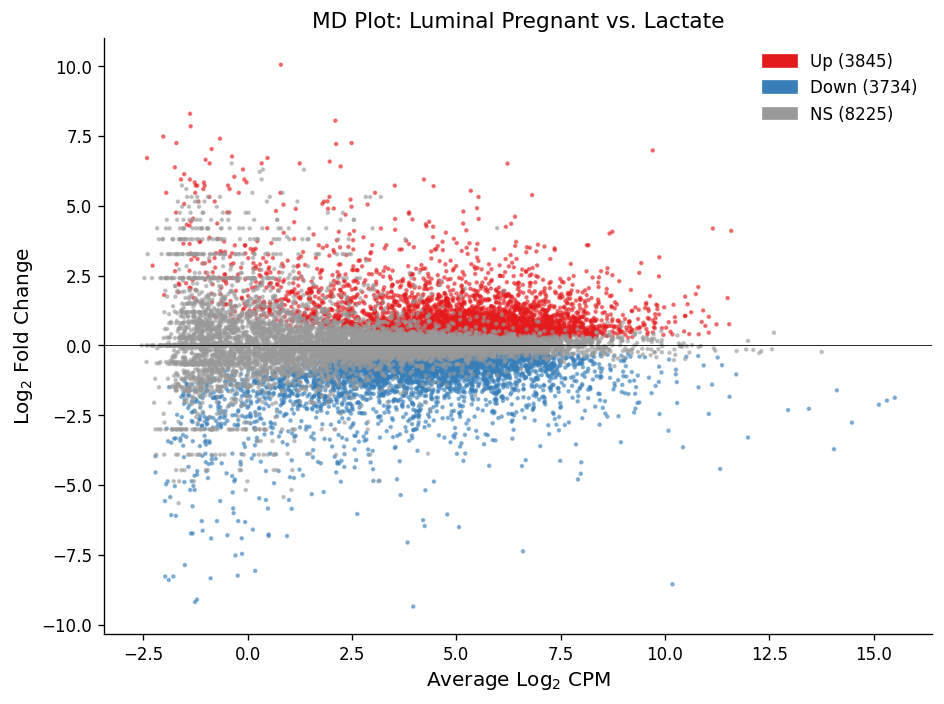

In [18]:
# MD plot
fig, ax = plt.subplots(figsize=(8, 6))
logfc_l = table_luminal['logFC'].values
logcpm_l = table_luminal['logCPM'].values
fdr_l = table_luminal['FDR'].values
sig_l = fdr_l < 0.05
colors_md_l = np.where(sig_l & (logfc_l > 0), '#E41A1C',
               np.where(sig_l & (logfc_l < 0), '#377EB8', '#999999'))
ax.scatter(logcpm_l, logfc_l, c=colors_md_l, s=3, alpha=0.5, rasterized=True)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Average Log$_2$ CPM'); ax.set_ylabel('Log$_2$ Fold Change')
ax.set_title('MD Plot: Luminal Pregnant vs. Lactate')
handles_md_l = [mpatches.Patch(color='#E41A1C', label=f'Up ({n_up_l})'),
                mpatches.Patch(color='#377EB8', label=f'Down ({n_down_l})'),
                mpatches.Patch(color='#999999', label=f'NS ({n_ns_l})')]
ax.legend(handles=handles_md_l, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

## 11. TREAT Analysis

TREAT tests whether genes are differentially expressed by more than a log-fold-change threshold of log2(1.5) = 0.58.

In [19]:
treat_basal = ep.glm_treat(fit, contrast=con_basal, lfc=0.58)
dt_treat_basal = ep.decide_tests(treat_basal)
print(f'TREAT Basal P vs L: Up={int(np.sum(dt_treat_basal > 0))}, Down={int(np.sum(dt_treat_basal < 0))}')

treat_luminal = ep.glm_treat(fit, contrast=con_luminal, lfc=0.58)
dt_treat_luminal = ep.decide_tests(treat_luminal)
print(f'TREAT Luminal P vs L: Up={int(np.sum(dt_treat_luminal > 0))}, Down={int(np.sum(dt_treat_luminal < 0))}')

TREAT Basal P vs L: Up=709, Down=414


TREAT Luminal P vs L: Up=1556, Down=1750


## 12. Heatmap of Top 50 DE Genes

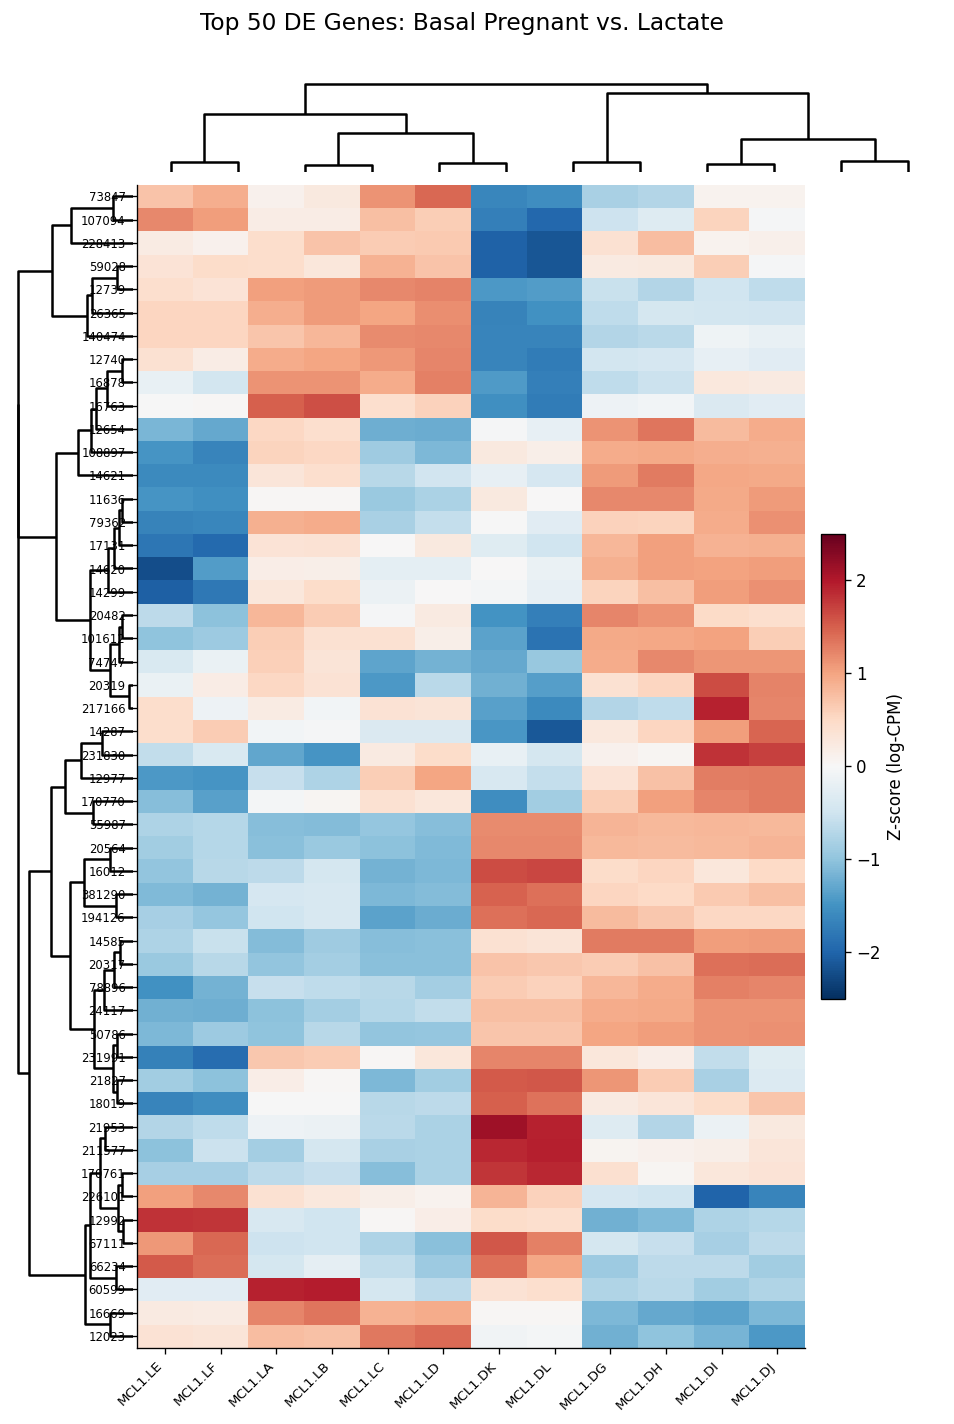

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

top50_genes = table_basal.head(50)
logcpm_all = ep.cpm(d_filt, log=True)
gene_id_filt = d_filt['genes']['GeneID'].values
gene_id_to_idx = {gid: i for i, gid in enumerate(gene_id_filt)}
top50_row_idx = [gene_id_to_idx[gid] for gid in top50_genes['GeneID'].values]

heatmap_df = pd.DataFrame(logcpm_all[top50_row_idx, :],
                           index=top50_genes['GeneID'].values, columns=sample_names)
heatmap_z = heatmap_df.subtract(heatmap_df.mean(axis=1), axis=0).divide(heatmap_df.std(axis=1), axis=0)

row_linkage = linkage(pdist(heatmap_z.values), method='complete')
col_linkage = linkage(pdist(heatmap_z.values.T), method='complete')
row_order = dendrogram(row_linkage, no_plot=True)['leaves']
col_order = dendrogram(col_linkage, no_plot=True)['leaves']

fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 2, width_ratios=[0.15, 1], height_ratios=[0.08, 1],
                       wspace=0.01, hspace=0.02)
ax_col_dendro = fig.add_subplot(gs[0, 1])
dendrogram(col_linkage, ax=ax_col_dendro, color_threshold=0, above_threshold_color='black')
ax_col_dendro.set_axis_off()
ax_row_dendro = fig.add_subplot(gs[1, 0])
dendrogram(row_linkage, ax=ax_row_dendro, orientation='left', color_threshold=0, above_threshold_color='black')
ax_row_dendro.set_axis_off()
ax_heat = fig.add_subplot(gs[1, 1])
reordered = heatmap_z.iloc[row_order, col_order]
im = ax_heat.imshow(reordered.values, aspect='auto', cmap='RdBu_r',
                     vmin=-2.5, vmax=2.5, interpolation='none')
ax_heat.set_xticks(range(len(reordered.columns)))
ax_heat.set_xticklabels(reordered.columns, rotation=45, ha='right', fontsize=8)
ax_heat.set_yticks(range(len(reordered.index)))
ax_heat.set_yticklabels(reordered.index, fontsize=7)
cbar = fig.colorbar(im, ax=ax_heat, shrink=0.4, pad=0.02)
cbar.set_label('Z-score (log-CPM)', fontsize=10)
fig.suptitle('Top 50 DE Genes: Basal Pregnant vs. Lactate', fontsize=14, y=0.92)
plt.show()

## 13. Summary

In [21]:
summary_data = {
    'Contrast': ['Basal: P vs L', 'Basal: P vs L', 'Luminal: P vs L', 'Luminal: P vs L'],
    'Method': ['QL F-test (FDR<0.05)', 'TREAT |logFC|>0.58', 'QL F-test (FDR<0.05)', 'TREAT |logFC|>0.58'],
    'Up': [n_up, int(np.sum(dt_treat_basal > 0)), n_up_l, int(np.sum(dt_treat_luminal > 0))],
    'Down': [n_down, int(np.sum(dt_treat_basal < 0)), n_down_l, int(np.sum(dt_treat_luminal < 0))],
}
summary_df = pd.DataFrame(summary_data)
summary_df['Total DE'] = summary_df['Up'] + summary_df['Down']
summary_df

,Contrast,Method,Up,Down,Total DE
0,Basal: P vs L,QL F-test (FDR<0.05),2828,2634,5462
1,Basal: P vs L,TREAT |logFC|>0.58,709,414,1123
2,Luminal: P vs L,QL F-test (FDR<0.05),3845,3734,7579
3,Luminal: P vs L,TREAT |logFC|>0.58,1556,1750,3306
